In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import math
import absl
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.__version__

'2.4.1'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
#data = input_data.read_data_sets('data/MNIST/', one_hot=True)
mnist = input_data.read_data_sets('./mnist', one_hot=True)  # they has been normalized to range (0,1)
test_x = mnist.test.images[:10000]
test_y = mnist.test.labels[:10000]

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)

In [6]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

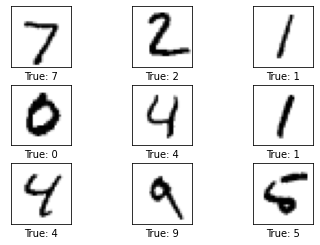

In [8]:
# Get the first images from the test-set.
images = mnist.test.images[0:9]

# Get the true classes for those images.
cls_true = mnist.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x') / 255

In [10]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [11]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [12]:
y_true_cls = tf.argmax(y_true, dimension=1)

In [13]:
conv1 = tf.layers.conv2d(   # shape (28, 28, 1)
    inputs=x_image,
    filters=16,
    kernel_size=5,
    strides=1,
    padding='same',
    activation=tf.nn.relu
)           # -> (28, 28, 16)
pool1 = tf.layers.max_pooling2d(
    conv1,
    pool_size=2,
    strides=2,
)           # -> (14, 14, 16)
conv2 = tf.layers.conv2d(pool1, 36, 5, 1, 'same', activation=tf.nn.relu)    # -> (14, 14, 36)
pool2 = tf.layers.max_pooling2d(conv2, 2, 2)    # -> (7, 7, 36)
flat = tf.reshape(pool2, [-1, 7*7*36])          # -> (7*7*36, )
output = tf.layers.dense(flat, 10)              # output layer

loss = tf.losses.softmax_cross_entropy(onehot_labels=y_true, logits=output)           # compute cost
train_op = tf.train.AdamOptimizer(0.001).minimize(loss) #learning rate is 0.1

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(y_true, axis=1), predictions=tf.argmax(output, axis=1),)[1]

/Users/gloria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/Users/gloria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/gloria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/pooling.py:310: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  warnings.warn('`tf.layers.max_pooling2d` is deprecated and '
/Users/gloria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core

In [14]:
session=tf.Session()

In [15]:
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
session.run(init_op)     # initialize var in graph

In [19]:
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')
def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 8)); plt.text(x, y, s, backgroundcolor=c, fontsize=8)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

Step: 0 | train loss: 0.1215 | test accuracy: 0.88


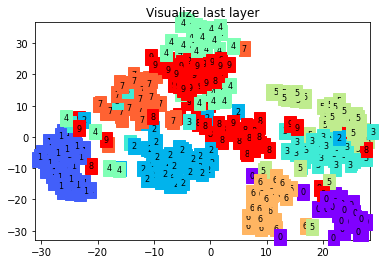

Step: 50 | train loss: 0.0317 | test accuracy: 0.89


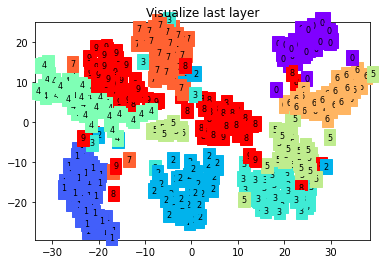

Step: 100 | train loss: 0.0747 | test accuracy: 0.90


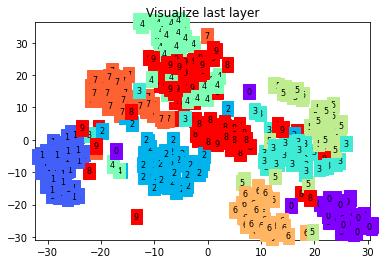

Step: 150 | train loss: 0.0562 | test accuracy: 0.90


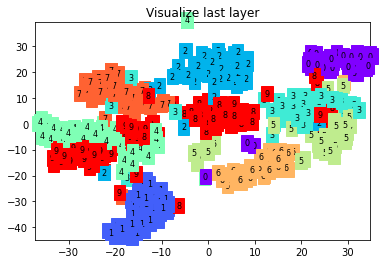

Step: 200 | train loss: 0.2000 | test accuracy: 0.91


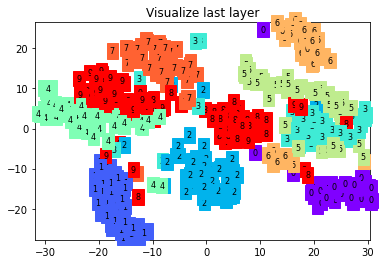

Step: 250 | train loss: 0.0456 | test accuracy: 0.91


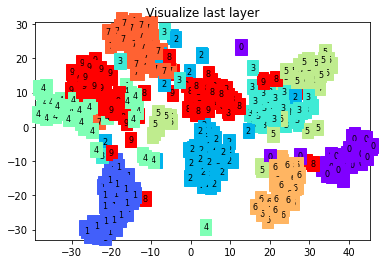

Step: 300 | train loss: 0.0360 | test accuracy: 0.91


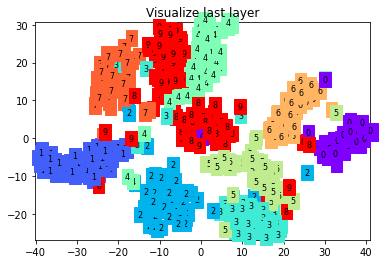

Step: 350 | train loss: 0.1473 | test accuracy: 0.92


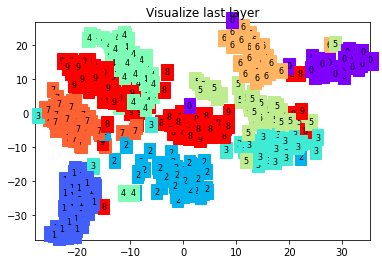

Step: 400 | train loss: 0.0445 | test accuracy: 0.92


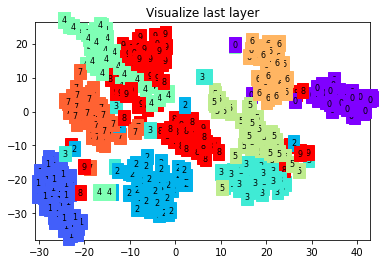

Step: 450 | train loss: 0.0198 | test accuracy: 0.92


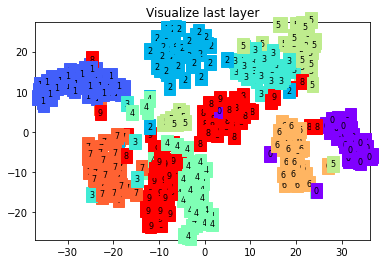

Step: 500 | train loss: 0.0282 | test accuracy: 0.93


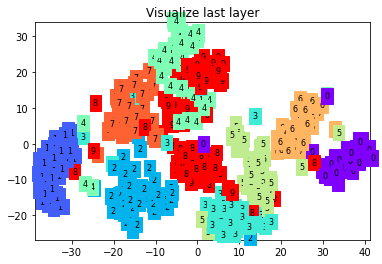

Step: 550 | train loss: 0.0504 | test accuracy: 0.93


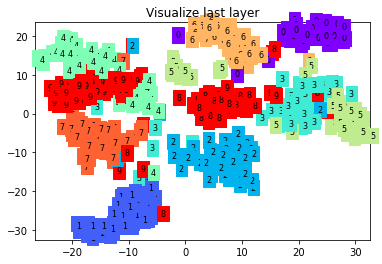

In [20]:


for step in range(600):
    b_x, b_y = mnist.train.next_batch(50) #Batch_size is 50
    _, loss_ = session.run([train_op, loss], {x: b_x, y_true: b_y})
    if step % 50 == 0:
        accuracy_, flat_representation = session.run([accuracy, flat], {x: test_x, y_true: test_y})
        print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

        if HAS_SK:
            # Visualization of trained flatten layer (T-SNE)
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = 500
            low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
            labels = np.argmax(test_y, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
plt.ioff()


In [18]:
test_output = session.run(output, {x: test_x[:10]})
pred_y = np.argmax(test_output, 1)
print(pred_y, 'prediction number')
print(np.argmax(test_y[:10], 1), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [ ]:
session.close()